In [1]:
import os
import json

import tensorflow as tf
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm

from tensor2tensor import problems
from tensor2tensor import models
from tensor2tensor.bin import t2t_decoder  # To register the hparams set
from tensor2tensor.utils import registry
from tensor2tensor.utils import trainer_lib
from tensor2tensor.data_generators import babi_qa

/home/mdehgha1/bin/anaconda3/envs/tf/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## HParams

In [4]:
# HParams
babi_task_id = 'qa3'
subset = "1k"
problem_name = 'babi_qa_sentence_task' + babi_task_id.replace("qa", "") + "_" + subset
model_name = "babi_r_transformer"
hparams_set = "r_transformer_act_step_position_timing_tiny"

data_dir = '~/babi/data/' + problem_name 

# PUT THE MODEL YOU WANT TO LOAD HERE!
CHECKPOINT = '~/babi/output/' + problem_name+ '/' + model_name +  '/' + hparams_set + '/'
print(CHECKPOINT)

/cns/lu-d/home/dehghani/babi/output_visualization/babi_qa_sentence_single_task3_10k/babi_r_transformer/r_transformer_act_step_position_timing_tiny/


In [5]:
_TASKS = {
      'qa1': 'qa1_single-supporting-fact',
      'qa2': 'qa2_two-supporting-facts',
      'qa3': 'qa3_three-supporting-facts',
      'qa4': 'qa4_two-arg-relations',
      'qa5': 'qa5_three-arg-relations',
      'qa6': 'qa6_yes-no-questions',
      'qa7': 'qa7_counting',
      'qa8': 'qa8_lists-sets',
      'qa9': 'qa9_simple-negation',
      'qa10': 'qa10_indefinite-knowledge',
      'qa11': 'qa11_basic-coreference',
      'qa12': 'qa12_conjunction',
      'qa13': 'qa13_compound-coreference',
      'qa14': 'qa14_time-reasoning',
      'qa15': 'qa15_basic-deduction',
      'qa16': 'qa16_basic-induction',
      'qa17': 'qa17_positional-reasoning',
      'qa18': 'qa18_size-reasoning',
      'qa19': 'qa19_path-finding',
      'qa20': 'qa20_agents-motivations'
  }

meta_data_filename = _TASKS[babi_task_id] + '-meta_data.json'
metadata_path = os.path.join(data_dir, meta_data_filename)


FLAGS = tf.flags.FLAGS
FLAGS.data_dir = data_dir

truncated_story_length = 130 if babi_task_id == 'qa3' else 70

with tf.gfile.GFile(metadata_path, mode='r') as f:
  metadata = json.load(f)
max_story_length = metadata['max_story_length']
max_sentence_length = metadata['max_sentence_length']
max_question_length = metadata['max_question_length']

print(max_story_length)
print(max_sentence_length)
print(max_question_length)

130
7
8


In [0]:
tf.reset_default_graph()

class bAbiACTVisualizer(object):
  """Helper object for creating act visualizations."""

  def __init__(
      self, hparams_set, model_name, data_dir, problem_name, beam_size=1):
    story, question, targets, samples, ponder_time = build_model(
        hparams_set, model_name, data_dir, problem_name, beam_size=beam_size)

    # Fetch the problem
    babi_problem = problems.problem(problem_name)
    encoders = babi_problem.feature_encoders(data_dir)

    self.story = story
    self.question = question
    self.targets = targets
    self.ponder_time = ponder_time
    self.samples = samples
    self.encoders = encoders

  def encode(self, story_str, question_str):
    """Input str to features dict, ready for inference."""
    
    story_str = babi_qa._normalize_string(story_str)
    question_str = babi_qa._normalize_string(question_str)
    story = story_str.strip().split('.')
    story = [self.encoders[babi_qa.FeatureNames.STORY].encode(sentence) 
                       for sentence in story[-truncated_story_length:]]
    question = self.encoders[babi_qa.FeatureNames.QUESTION].encode(question_str)
     
    for sentence in story:
      for _ in range(max_sentence_length - len(sentence)):
        sentence.append(babi_qa.PAD)
      assert len(sentence) == max_sentence_length

    for _ in range(max_story_length - len(story)):
      story.append([babi_qa.PAD for _ in range(max_sentence_length)])

    for _ in range(max_question_length - len(question)):
      question.append(babi_qa.PAD)

    assert len(story) == max_story_length
    assert len(question) == max_question_length   

    story_flat = [token_id for sentence in story for token_id in sentence]
    
    batch_story = np.reshape(np.array(story_flat), 
                             [1, max_story_length, max_sentence_length, 1])
    batch_question = np.reshape(np.array(question), 
                         [1, 1, max_question_length, 1])
    return batch_story, batch_question

  def decode_story(self, integers):
    """List of ints to str."""
    integers = np.squeeze(integers).tolist()
    story = []
    for sent in integers:
      sent_decoded = self.encoders[babi_qa.FeatureNames.STORY].decode_list(sent)
      sent_decoded.append('.')
      story.append(sent_decoded)
    return story
  
  def decode_question(self, integers):
    """List of ints to str."""
    integers = np.squeeze(integers).tolist()
    return self.encoders[babi_qa.FeatureNames.QUESTION].decode_list(integers)
  
  def decode_targets(self, integers):
    """List of ints to str."""
    integers = np.squeeze(integers).tolist()
    return self.encoders["targets"].decode([integers])

  def get_vis_data_from_string(self, sess, story_str, question_str):
    """Constructs the data needed for visualizing ponder_time.

    Args:
      sess: A tf.Session object.
      input_string: The input setence to be visulized.

    Returns:
      Tuple of (
          output_string: The answer
          input_list: Tokenized input sentence.
          output_list: Tokenized answer.
          ponder_time: ponder_time matrices;
          )
    """
    encoded_story, encoded_question = self.encode(story_str, question_str)

    # Run inference graph to get the label.
    out = sess.run(self.samples, {
        self.story: encoded_story,
        self.question: encoded_question,
    })

    # Run the decoded answer through the training graph to get the
    # ponder_time tensors.
    ponder_time = sess.run(self.ponder_time, {
        self.story: encoded_story,
        self.question: encoded_question,
        self.targets: np.reshape(out, [1, -1, 1, 1]),
    })
    
    output = self.decode_targets(out)
    story_list = self.decode_story(encoded_story)
    question_list = self.decode_question(encoded_question)
    
    return story_list, question_list, output, ponder_time


def build_model(hparams_set, model_name, data_dir, problem_name, beam_size=1):
  """Build the graph required to featch the ponder_times.

  Args:
    hparams_set: HParams set to build the model with.
    model_name: Name of model.
    data_dir: Path to directory contatining training data.
    problem_name: Name of problem.
    beam_size: (Optional) Number of beams to use when decoding a traslation.
        If set to 1 (default) then greedy decoding is used.

  Returns:
    Tuple of (
        inputs: Input placeholder to feed in ids.
        targets: Targets placeholder to feed to th when fetching
            ponder_time.
        samples: Tensor representing the ids of the translation.
        ponder_time: Tensors representing the ponder_time.
    )
  """
  hparams = trainer_lib.create_hparams(
      hparams_set, data_dir=data_dir, problem_name=problem_name)
  babi_model = registry.model(model_name)(
      hparams, tf.estimator.ModeKeys.EVAL)
          
  story = tf.placeholder(tf.int32, shape=(
      1, max_story_length, max_sentence_length, 1), 
                            name=babi_qa.FeatureNames.STORY)
  question = tf.placeholder(tf.int32, shape=(
      1, 1, max_question_length, 1), 
                            name=babi_qa.FeatureNames.QUESTION)
  targets = tf.placeholder(tf.int32, shape=(1, 1, 1, 1), name='targets')
  
  babi_model({
      babi_qa.FeatureNames.STORY: story,
      babi_qa.FeatureNames.QUESTION: question,
      'targets': targets,
  })

  # Must be called after building the training graph, so that the dict will
  # have been filled with the ponder_time tensors. BUT before creating the
  # interence graph otherwise the dict will be filled with tensors from
  # inside a tf.while_loop from decoding and are marked unfetchable.
  ponder_time = get_ponder_mats(babi_model)

  with tf.variable_scope(tf.get_variable_scope(), reuse=True):
    samples = babi_model.infer({
       babi_qa.FeatureNames.STORY: story,
       babi_qa.FeatureNames.QUESTION: question,
    }, beam_size=beam_size)['outputs']

  return story, question, targets, samples, ponder_time


def get_ponder_mats(babi_model):
  """Get's the tensors representing the ponder_time from a build model.

  The ponder_time are stored in a dict on the Transformer object while building
  the graph.

  Args:
    babi_model: Transformer object to fetch the ponder_time from.

  Returns:
  Tuple of ponder_time matrices
  """
#   print([n.name for n in tf.get_default_graph().as_graph_def().node])
  attention_tensor_name = "babi_r_transformer/parallel_0_5/babi_r_transformer/body/encoder/r_transformer_act/while/self_attention/multihead_attention/dot_product_attention/attention_weights"
  ponder_time_tensor_name = "babi_r_transformer/parallel_0_5/babi_r_transformer/body/enc_ponder_times:0"
  ponder_time =  tf.get_default_graph().get_tensor_by_name(ponder_time_tensor_name)


  return ponder_time

In [0]:
ponder_visualizer = bAbiACTVisualizer(hparams_set, model_name, data_dir, problem_name, beam_size=1)

In [0]:
tf.Variable(0, dtype=tf.int64, trainable=False, name='global_step')

sess = tf.train.MonitoredTrainingSession(
    checkpoint_dir=CHECKPOINT,
    save_summaries_secs=0,
)

In [0]:
if babi_task_id == 'qa1':
#   input_story = "John travelled to the hallway.Mary journeyed to the bathroom."
#   input_question = "Where is John?" #hallway
  
  input_story = "John travelled to the hallway.Mary journeyed to the bathroom.Daniel went back to the bathroom.John moved to the bedroom."
  input_question = "Where is Mary?" #bathroom

elif babi_task_id == 'qa2':
  input_story = "Mary got the milk there.John moved to the bedroom.Sandra went back to the kitchen.Mary travelled to the hallway."
  input_question = "Where is the milk?" #hallway
  
#   input_story = "Mary got the milk there.John moved to the bedroom.Sandra went back to the kitchen.Mary travelled to the hallway.John got the football there.John went to the hallway."
#   input_question = "Where is the football?" #hallway

elif babi_task_id == 'qa3':
  input_story = "Mary got the milk.John moved to the bedroom.Daniel journeyed to the office.John grabbed the apple there.John got the football.John journeyed to the garden.Mary left the milk.John left the football.Daniel moved to the garden.Daniel grabbed the football.Mary moved to the hallway.Mary went to the kitchen.John put down the apple there.John picked up the apple.Sandra moved to the hallway.Daniel left the football there.Daniel took the football.John travelled to the kitchen.Daniel dropped the football.John dropped the apple.John grabbed the apple.John went to the office.Sandra went back to the bedroom.Sandra took the milk.John journeyed to the bathroom.John travelled to the office.Sandra left the milk.Mary went to the bedroom.Mary moved to the office.John travelled to the hallway.Sandra moved to the garden.Mary moved to the kitchen.Daniel took the football.Mary journeyed to the bedroom.Mary grabbed the milk there.Mary discarded the milk.John went to the garden.John discarded the apple there."
  input_question = "Where was the apple before the bathroom?" #office
  
#   input_story = "Mary got the milk.John moved to the bedroom.Daniel journeyed to the office.John grabbed the apple there.John got the football.John journeyed to the garden.Mary left the milk.John left the football.Daniel moved to the garden.Daniel grabbed the football.Mary moved to the hallway.Mary went to the kitchen.John put down the apple there.John picked up the apple.Sandra moved to the hallway.Daniel left the football there.Daniel took the football.John travelled to the kitchen.Daniel dropped the football.John dropped the apple.John grabbed the apple.John went to the office.Sandra went back to the bedroom.Sandra took the milk.John journeyed to the bathroom.John travelled to the office.Sandra left the milk.Mary went to the bedroom.Mary moved to the office.John travelled to the hallway.Sandra moved to the garden.Mary moved to the kitchen.Daniel took the football.Mary journeyed to the bedroom.Mary grabbed the milk there.Mary discarded the milk.John went to the garden.John discarded the apple there.Sandra travelled to the bedroom.Daniel moved to the bathroom."
#   input_question = "Where was the apple before the hallway?" #office
 


In [12]:
story_text, question_text, output, ponder_time = ponder_visualizer.get_vis_data_from_string(sess, input_story, input_question)
# print(output)
# print(story_text)
# print(question_text)

inp_text = []
for sent in story_text:
  inp_text.append(' '.join(sent))
inp_text.append(' '.join(question_text))
ponder_time = np.squeeze(np.array(ponder_time)).tolist()
# print(ponder_time)
def pad_remover(inp_text, ponder_time):
  pad_sent_index = [ i for i, sent in enumerate(inp_text) if sent.startswith('<pad>')]
  start = min(pad_sent_index)
  end = max(pad_sent_index)
  filtered_inp_text = inp_text[:start] + inp_text[end+1:]
  filtered_inp_text = [sent.replace('<pad> ', '') for sent in filtered_inp_text]
  filtered_ponder_time = ponder_time[:start] + ponder_time[end+1:] 
  return filtered_inp_text, filtered_ponder_time


filtered_inp_text, filtered_ponder_time = pad_remover(inp_text, ponder_time)
for sent in filtered_inp_text:
  print(sent)
print(output)
print(filtered_ponder_time)

Mary got the milk .
John moved to the bedroom .
Daniel journeyed to the office .
John grabbed the apple there .
John got the football .
John journeyed to the garden .
Mary left the milk .
John left the football .
Daniel moved to the garden .
Daniel grabbed the football .
Mary moved to the hallway .
Mary went to the kitchen .
John put down the apple there .
John picked up the apple .
Sandra moved to the hallway .
Daniel left the football there .
Daniel took the football .
John travelled to the kitchen .
Daniel dropped the football .
John dropped the apple .
John grabbed the apple .
John went to the office .
Sandra went back to the bedroom .
Sandra took the milk .
John journeyed to the bathroom .
John travelled to the office .
Sandra left the milk .
Mary went to the bedroom .
Mary moved to the office .
John travelled to the hallway .
Sandra moved to the garden .
Mary moved to the kitchen .
Daniel took the football .
Mary journeyed to the bedroom .
Mary grabbed the milk there .
Mary disca

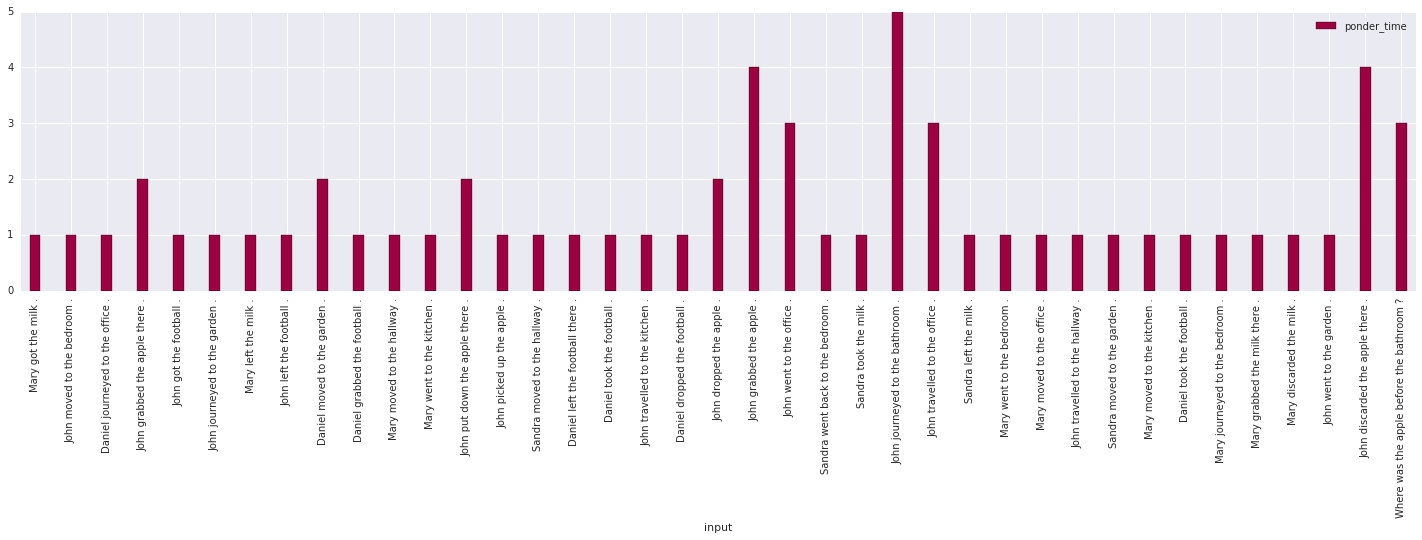

In [13]:
df = pd.DataFrame(
    {'input': filtered_inp_text,
     'ponder_time': filtered_ponder_time,
    })

f_size = (10,5)
if babi_task_id == 'qa2':
  f_size = (15,5)
if babi_task_id == 'qa3':
  f_size = (25,5)
df.plot(kind='bar', x='input', y='ponder_time', rot=90,  width=0.3, figsize=f_size, cmap='Spectral')